# Tenure of participation in IETF Working Groups

We want to analyze participants and patterns of participation across IETF groups. 

For this notebook we look at **tenure**: what are the lengths of participation? Are there new cohorts of participation over time? What is attrition like in IETF mailing list participation? How long do people participate for? How many messages do people send?

<div class="alert alert-info"><b>TODO</b>
Paragraphs that note future work or additional data analysis to try are marked like this paragraph.
</div>

## Setup and load data

Start by importing the necessary libraries.

In [508]:
%matplotlib inline
import bigbang.mailman as mailman
import bigbang.process as process
import bigbang.parse
from bigbang.parse import get_date
from bigbang.archive import Archive
import bigbang.utils as utils
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
import pytz
import pickle
import os
import csv
import re
import scipy
import email
import gc
import powerlaw
import mpmath

In [288]:
plt.rcParams['axes.facecolor'] = 'white'
import seaborn as sns
sns.set()
sns.set_style("white")

In [139]:
def convert_ordinals_to_dates(s): # convenience function for rendering dates in describe tables
    n = []
    if s.name in ['Earliest Date', 'Latest Date']:
        for i, value in s.iteritems():
            if i not in ['std','count']:
                n.append(datetime.date.fromordinal(int(value)).isoformat())
            else:
                n.append(value)
        return pd.Series(data=n, index=s.index, dtype=str)
    return s
def describe_with_dates(df):
    return df.describe().apply(convert_ordinals_to_dates,axis=0)

We'll load data of tenure (earliest date of a message sent, latest date of a message sent, total number of messages sent) that I've already made into a (large) CSV, using the script `tenure.py`. This particular corpus includes all the WG mailing lists for still active WGs that I was able to crawl (**322** successfully collected out of the **364** lists attempted).

In [140]:
tenure_path = '../../ietf-archives/combined-tenure.csv'
tenure_df = pd.read_csv(tenure_path)
describe_with_dates(tenure_df)

,Earliest Date,Total Messages,Latest Date
count,120527,120555.000000,120527
mean,2006-06-11,11.138559,2006-11-21
std,7905.45,121.384299,6829.6
min,0100-01-10,0.000000,0100-01-12
25%,2004-09-30,1.000000,2005-01-18
50%,2007-03-17,1.000000,2007-04-26
75%,2007-12-27,2.000000,2008-01-16
max,2017-10-20,20279.000000,2017-10-23


In [6]:
tenure_df['Total Messages'].sum()

1342809.0

That's over **120,000** senders (although some of those are duplicates we will combine in a later step) that have sent over **1.3 million** messages.

We have some outliers / bad data that crept in. Let's see how much and ignore them for now.

In [7]:
tenure_df[tenure_df['Earliest Date'] < 726468].count()

From              45
Earliest Date     45
Total Messages    45
Latest Date       45
dtype: int64

We'll just use data from the 1990s and later, as I suspect earlier records were using incorrect dates (like a handful at the Unix epoch of January 1, 1970). 

<div class="alert alert-info"><b>TODO</b>
It's not very many people (27 out of 120,000) although a couple are significant senders, so sometime it would be good to just drop individual messages with bad dates, rather than the person's whole tenure.</div>

In [142]:
tenure_df = tenure_df[tenure_df['Earliest Date'] > 726468]

## Combining likely duplicates

More cleanup: entity resolution. Many of these senders are probably duplicates, where a single person has used more than one email address, or even the same email address but a different `From` header, to send messages over time. We want to take a pass at combining those duplicate rows. (For other notebooks or in more focused studies, we might use other entity resolution methods, including identifying clusters of somewhat similar names and manual verification. This dataset may be too large for that.)

In [149]:
resolution_df = tenure_df.copy(deep=True)

In [277]:
name_and_email_columns = resolution_df['From'].apply(
    lambda x: pd.Series(
        [bigbang.parse.normalize_email_address(email.utils.parseaddr(x)[1]),
         bigbang.parse.tokenize_name(bigbang.parse.clean_name(email.utils.parseaddr(x)[0]))],
        index=['email','name']))

In [189]:
resolution_df = resolution_df.join(name_and_email_columns, how='inner')

First, let's see the number of exact duplicates, when we just compare normalized email address and normalized name for matching purposes.

In [191]:
resolution_df['email'].describe()

count                      120482
unique                     105495
top       dnsext-archive@ietf.org
freq                          162
Name: email, dtype: object

In [192]:
resolution_df['name'].describe()

count                   110294
unique                   88282
top       delivery mail system
freq                       501
Name: name, dtype: object

While there are 120,482 distinct From headers, there are only **105,495** unique normalized email addresses, so about 12% are duplicates along that measure. It's less immediately clear what to conclude from the distinct names; about 10,000 of our entries didn't have a name at all, and it looks like 500 of them are auto-responders (which could have different email addresses from different domains, but none of those are really meaningful messages to work with).

What are the non-unique normalized names?

In [197]:
names = resolution_df['name'].copy(deep=True)
name_counts = names.value_counts()
name_counts[name_counts > 1][:30]

delivery mail system        501
delivery mail subsystem     256
j smith vanessa              88
����                         86
������                       70
a davis paul                 60
good news                    46
erectile                     40
matchmaker news              39
john                         38
a clark jennifer             37
cialis                       34
official site viagra �       34
homburg philip               33
richard                      31
board lottery                29
��������                     28
k lee richard                28
internal revenue service     28
a norman steven              27
job news opportunity         26
award dept                   26
robert                       26
�����                        25
consumer research            25
alert broker                 25
inc viagra                   24
hannes tschofenig            23
alert pinksheets             23
burger eric                  23
Name: name, dtype: int64

This subset of the most common duplicate names gives us a good sense of the range of duplicates. Some are email system autoresponses, some are common spam names, some are generic first names, and some are specific individuals where for some reason we have lots of different entries for them.

Let's group and aggregate to combine the most clear duplicates. For email address, we can just group on that column, and then aggregate, where the function for aggregating each column is appropriate to the meaning of that column (summing total messages, take the minimum of the earliest date and the maximum of the latest date, take the longest name). The name column is a little more complicated; we split into two dataframes based on a mask where it looks like a complex enough name to match with (has two words). Then we can do the same kind of grouping and aggregation on the part that has a name worth matching, and then append the other dataframe back in.

In [235]:
email_grouped = resolution_df.groupby('email', as_index=False)

In [238]:
email_aggregated = email_grouped.aggregate({
    'Earliest Date': np.min,
    'Latest Date': np.max,
    'Total Messages': np.sum,
    'name': lambda x: x.iloc[x.str.len().values.argmax()], # the longest string
    'From': lambda x: x.iloc[x.str.len().values.argmax()]
})

In [239]:
describe_with_dates(email_aggregated)

,Earliest Date,Total Messages,Latest Date
count,105495,105495.000000,105495
mean,2006-07-28,12.705493,2007-01-12
std,1310.31,162.005657,1407.12
min,1990-01-29,1.000000,1990-01-29
25%,2004-10-20,1.000000,2005-02-19
50%,2007-03-05,1.000000,2007-04-19
75%,2007-11-29,2.000000,2007-12-21
max,2017-10-20,39302.000000,2017-10-23


In [241]:
name_for_matching = email_aggregated['name'].map(lambda x: x if ' ' in x else None, na_action='ignore')

In [248]:
# make separate dataframes for names that are worth matching and names that aren't
email_aggregated_no_name_for_matching = email_aggregated[name_for_matching.isnull()].copy(deep=True)
email_aggregated_for_name_matching = email_aggregated[name_for_matching.notnull()].copy(deep=True)

In [251]:
len(email_aggregated_no_name_for_matching) + len(email_aggregated_for_name_matching)

105495

In [252]:
name_grouped = email_aggregated_for_name_matching.groupby('name', as_index=False)

In [253]:
len(name_grouped)

71881

In [254]:
name_aggregated = name_grouped.aggregate({
    'Earliest Date': np.min,
    'Latest Date': np.max,
    'Total Messages': np.sum,
    'From': lambda x: x.iloc[x.str.len().values.argmax()], # longest From header
    'email': lambda x: x.value_counts().idxmax() # most common email in the group
})

In [257]:
resolved_df = name_aggregated.append(email_aggregated_no_name_for_matching, ignore_index=True)

In [260]:
describe_with_dates(resolved_df)

,Earliest Date,Latest Date,Total Messages
count,94723,94723,94723.000000
mean,2006-06-30,2007-02-09,14.150375
std,1272.83,1379.8,178.223995
min,1990-01-29,1990-01-29,1.000000
25%,2004-11-12,2005-03-27,1.000000
50%,2007-03-06,2007-05-06,1.000000
75%,2007-11-16,2007-12-17,2.000000
max,2017-10-20,2017-10-23,39302.000000


With that entity resolution step done, we now have **94,723** senders. We'll use this consolidated dataframe for the rest of our calculations.

In [261]:
tenure_df = resolved_df

## Initial exploration

Just to get started visualizing this data, we'll create a histogram of people and when they sent their first message to any list.

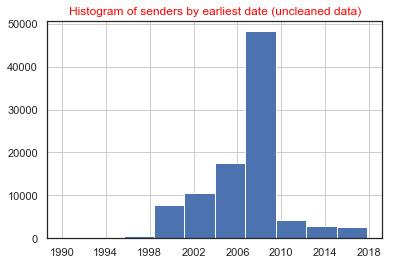

In [294]:
fig = plt.figure()
tenure_df['Earliest Date'].hist()
fig.axes[0].xaxis_date()
plt.title('Histogram of senders by earliest date (uncleaned data)', {'color':'red'})
plt.show()

We have a peak in late-2000s on new participation, with a sudden drop-off. However, that is likely just be where the peak of this corpus of messages is present, including one-off spam messages. (The histogram also peaks there for last message sent.)

It would be more useful to limit our analysis to people who have sent at least a few messages to ignore these peaks, which we'll do in the following sections.

## For how long do participants remain?

We can calculate a "tenure" concept, which is the number of days between your first message to an IETF list and your latest message.

In [263]:
tenure_df['Tenure'] = tenure_df['Latest Date'] - tenure_df['Earliest Date']

In [264]:
describe_with_dates(tenure_df)

,Earliest Date,Latest Date,Total Messages,Tenure
count,94723,94723,94723.000000,94723.000000
mean,2006-06-30,2007-02-09,14.150375,223.524308
std,1272.83,1379.8,178.223995,792.749162
min,1990-01-29,1990-01-29,1.000000,0.000000
25%,2004-11-12,2005-03-27,1.000000,0.000000
50%,2007-03-06,2007-05-06,1.000000,0.000000
75%,2007-11-16,2007-12-17,2.000000,0.000000
max,2017-10-20,2017-10-23,39302.000000,8134.000000


Let's graph data for people for whom we have at least a few messages.

In [265]:
working_data = tenure_df[tenure_df['Total Messages'] > 3]

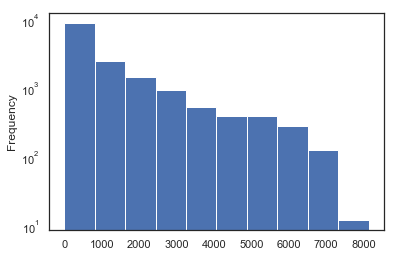

In [266]:
working_data['Tenure'].plot(kind ='hist',logy=True)

The distribution of tenure looks a little like a power law, although not exactly. (The above graph is log scale in the y dimension.) Most people have short tenures, with fewer and fewer people as the tenure extends.

<div class="alert alert-info"><b>TODO</b>
What are the odds that a participant will have a tenure of a particular length?
</div>

#### Comparing power law distributions

We'll look at these methods in more detail in the distribution of how many messages people send, but here are some quick calculations regarding different heavy-tail distributions.

In [528]:
tenure_fit_data = working_data.copy(deep=True)

In [529]:
tenure_fit_data['Tenure'] = tenure_fit_data['Tenure'] + 1 
# for these calculations, we need to increase all the tenure values by 1
# if you sent multiple messages on one day, that's still really a tenure of 1
# and our powerlaw module will ignore anything with value 0

tenure_fit = powerlaw.Fit(tenure_fit_data['Tenure'], xmin=1, xmax=8000)

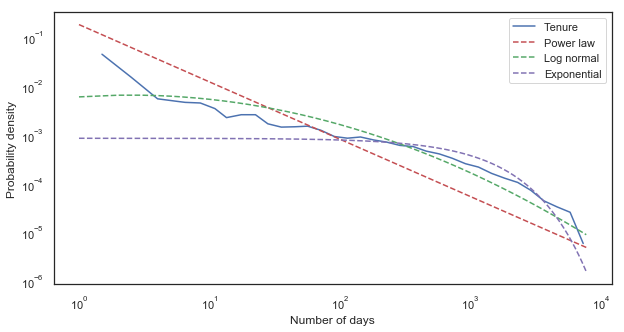

In [537]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes()
powerlaw.plot_pdf(tenure_fit_data['Tenure'], ax=ax, color='b', label='Tenure')
tenure_fit.power_law.plot_pdf(ax=ax, color='r', linestyle='--', label='Power law')
tenure_fit.lognormal.plot_pdf(ax=ax, color='g', linestyle='--', label='Log normal')
tenure_fit.exponential.plot_pdf(ax=ax, color='m', linestyle='--', label='Exponential')

ax.set_xlabel('Number of days')
ax.set_ylabel('Probability density')
ax.legend()
fig.show()

In [533]:
R, p = tenure_fit.distribution_compare('lognormal', 'power_law', normalized_ratio=True)
print R, p

67.18840340719531 0.0


In [534]:
R, p = tenure_fit.distribution_compare('lognormal', 'exponential', normalized_ratio=True)
print R, p

7.368081842789917 1.7310051462272037e-13


The distribution seems to be lognormal (and much more likely log normal than a power law or an exponential), although the fit isn't especially close.

---

### How does tenure relate to when a participant started?

This plot shows the density of people around when they first sent a message and how long their tenure has been. Maybe this can help us answer the question: are the earlier participants more likely to be long-lasting? 

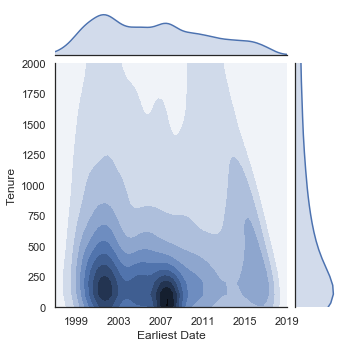

In [267]:
fig = sns.jointplot(kind='kde', 
                    data = working_data, 
                    x='Earliest Date', 
                    y='Tenure', 
                    xlim=(datetime.date(1997,1,1).toordinal(),datetime.date(2019,1,1).toordinal()), 
                    ylim=(0, 2000),
                    height=5)
fig.ax_joint.xaxis_date()
fig.savefig('graphs/tenure-density-plot.png',dpi=300)

This suggests that that isn't the case, or at least that it isn't unimodal. It appears that the longer-lasting participants are either the early joiners or the recent joiners, more than the density of those who joined in the mid 2000s. 

As a caveat, that might also be an artifact of the current corpus being WGs that are still active -- it might be that participation in groups that are still active 20 years later is different than participants who joined groups that have been closed in the meantime. And this graph is substantially different once we've done the entity resolution step; it seems to be especially important for earlier and longer-time participants to capture changes in email address or From headers.

For the subset of senders who have more than 3 total messages, let's see when they first and last sent messages.

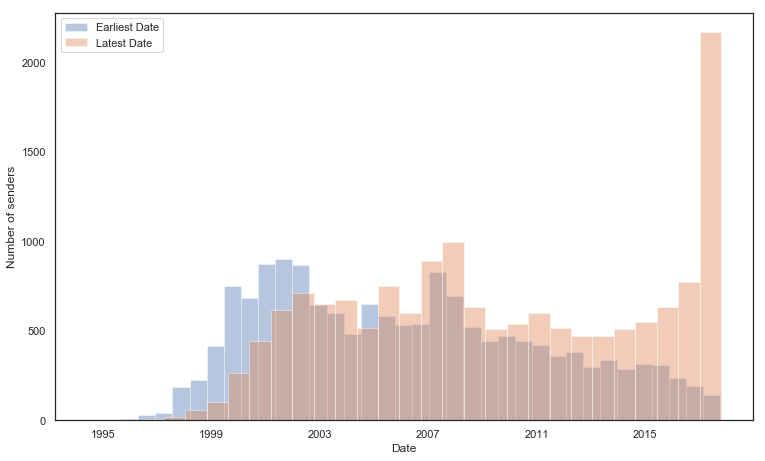

In [268]:
fig = plt.figure(figsize=(12.5, 7.5))

ax = sns.distplot(working_data['Earliest Date'], label='Earliest Date', norm_hist=False, kde=False)
sns.distplot(working_data['Latest Date'], label='Latest Date', ax=ax, norm_hist=False, kde=False)
ax.legend()
ax.xaxis_date()
ax.set_xlabel('Date')
ax.set_ylabel('Number of senders')
fig.savefig('graphs/earliest-latest-histograms.png',dpi=300)

Latest Date has a histogram peak in the most recent year because for everyone who's still sending messages, their last message can't be later than this year, and that might also explain some of the increase up to that peak. But the decrease in Earliest Date frequency in more recent years is a little more surprising. Is IETF getting fewer newcomer participants in the past few years?

There are a couple of alternative explanations that we might explore before drawing a strong conclusion from that. Is message traffic overall decreasing (or increasing) during that same period of new mailing list participant decline? If it is, that might be evidence of a shift away from mailing list traffic, rather than a shift away from new participants, and maybe Github issue threads increased as a substitute. Also, since we limited our corpus to people who sent at least a few messages, it could be that some participants send multiple messages but quite spread out, over a few years even, and so if those people started earlier, they're in the corpus, but if they haven't reached the cutoff yet (at least 4 messages) but would in the future, they're excluded.

From the above, we know a little of how many people first and last sent messages for any given timeframe, but that doesn't give us a view of the cohorts, of who is participating at a given time and when they started. I'd like to show overlapping line segments in order to give an impression of the overlapping tenures of participation. Let's try?

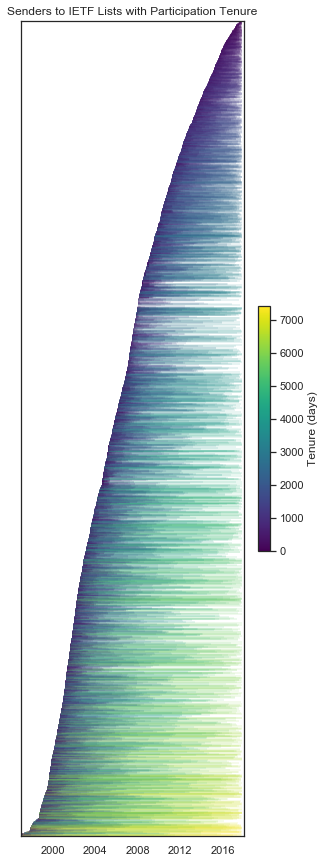

In [269]:
sorted_df = working_data.sort_values(by=['Earliest Date'])

ys= np.arange(sorted_df['From'].count())
segments = []
for y in ys:
    start = [sorted_df['Earliest Date'].iloc[y], y]
    end = [sorted_df['Latest Date'].iloc[y], y]
    segments.append([start,end])
line_segments = matplotlib.collections.LineCollection(segments, 
                                                      linewidths=[0.2], 
                                                      cmap='viridis', 
                                                      norm=matplotlib.colors.Normalize(vmin=0,vmax=7408))
line_segments.set_array(sorted_df['Tenure'])

fig = plt.figure(figsize=(5, 15))
ax = plt.axes()
ax.set_xlim(datetime.date(1997,1,1).toordinal(),datetime.date(2018,1,1).toordinal())
ax.set_ylim(ys.min(), ys.max())
ax.xaxis_date()
ax.yaxis.set_visible(False)
ax.add_collection(line_segments)
cb = fig.colorbar(line_segments, shrink=0.3)
cb.set_label('Tenure (days)')
ax.set_title('Senders to IETF Lists with Participation Tenure')
fig.savefig('graphs/tenure-lines.png',dpi=300)

This graph is colorful, and I'd like to think it's aesthetically pleasing, but what can we learn from it? It seems that no dramatic trend stands out. There is a mix of short-lived and long-lived participants at each starting time. There are a couple of small gaps in the mid-2000s where batches of new participants seemed not to have much staying power.

Participants who joined more recently are perhaps more likely to still be participating, but of course those participants can't have as long a potential tenure.

<div class="alert alert-info"><b>TODO</b>
Perhaps another way to show that data more quantitatively is to graph the cumulative percentage of people who first started sending messages in a particular year who have participated for longer than X days. That would let us compare directly for any given timeframe (say, 2+ years) whether any particular starting point is more likely to have that timeframe. This might be similar to the density plot, but with aggregation and percentages, rather than comparing colors for density.
</div>

## How many messages do people send?

This dataset also includes the total number of messages that each person has sent. Do earlier participants, or longer-lasting participants, always send more messages? Or might people who only participate in one working group for a year or two often send many messages during that time?

First, let's get an overview of the data on the total messages sent by each person. (As above, our working data set is limited to people who have sent more than 3 messages.)

In [270]:
working_data['Total Messages'].describe()

count    15654.000000
mean        79.564392
std        432.534999
min          4.000000
25%          6.000000
50%         11.000000
75%         35.000000
max      39302.000000
Name: Total Messages, dtype: float64

[None]

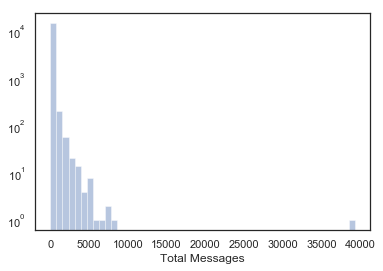

In [271]:
fig = sns.distplot(working_data['Total Messages'], hist=True, kde=False)
fig.set(yscale="log")

With some outliers (a handful of senders have sent several thousand messages, including one that sent almost 40,000 messages), the distribution is intensely skewed-right and largely unimodal.

If we exclude the outliers, can we calculate a model to fit to this histogram of number of senders who have sent a certain number of messages? (Does the model that fits the distribution tell us something about what kind of process generates the social activity of participation in these mailing lists?)

In [501]:
total_messages_excluding_outliers = working_data[working_data['Total Messages'] < 5000]

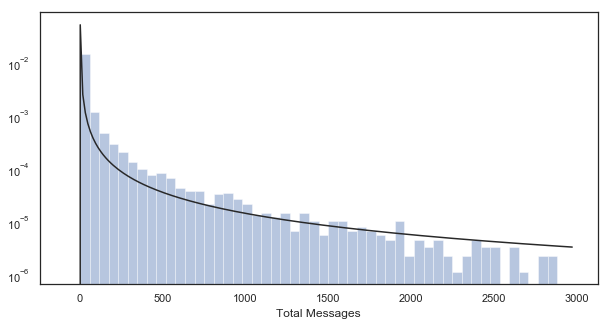

In [491]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes()
sns.distplot(working_data[working_data['Total Messages'] < 3000]['Total Messages'], ax=ax, hist=True, kde=False, norm_hist=True,
            fit=scipy.stats.lognorm
            )

# #fit_params = scipy.stats.lognorm.fit(total_messages_excluding_outliers['Total Messages'])
# new_params = (fit.lognormal.sigma, 4, np.abs(fit.lognormal.mu))
# fit_pdf = scipy.stats.lognorm.pdf(range(5000), *new_params)
# ax.plot(fit_pdf)
ax.set(yscale="log")
fig.show()

In [538]:
fit = powerlaw.Fit(total_messages_excluding_outliers['Total Messages'], xmin=4)

Is the distribution of total messages more like a power law, or more like an exponential? That is, does it have a heavy tail at all?

In [503]:
R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print R, p

46.33205896295737 0.0


It is with extremely high confidence a lot more like a power law. Our initial characterization of it as a heavy tail is confirmed.

But what kind of heavy tail distribution is it? What about a log-normal?

In [504]:
R, p = fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True)
print R, p

-2.285337563807328 0.02229304194966968


I believe this suggests that it's more likely to be a log-normal distribution than a power law, with a _p_ value of 0.02.

In [505]:
print fit.lognormal.mu, fit.lognormal.sigma

-44.39529217308272 8.35286062498085


However, a truncated power law could also fit it even more closely.

In [506]:
R, p = fit.distribution_compare('lognormal', 'truncated_power_law', normalized_ratio=True)
print R, p

-17.330711793896327 2.7589272288294113e-67


We can visualize these different fits against the data if we graph the probability density functions (of the data and the fits) rather than just the histogram. Both the powerlaw and log normal look pretty close to the data.

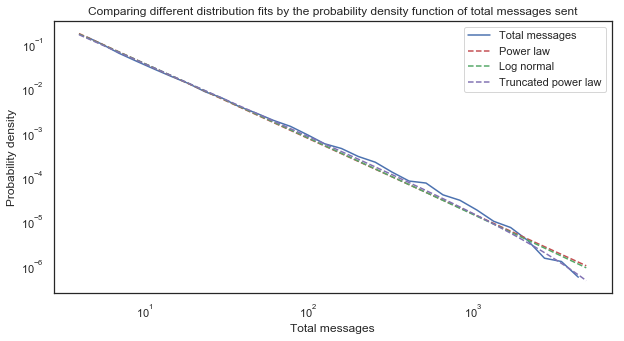

In [539]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes()
powerlaw.plot_pdf(total_messages_excluding_outliers['Total Messages'], ax=ax, color='b', label='Total messages')
fit.power_law.plot_pdf(ax=ax, color='r', linestyle='--', label='Power law')
fit.lognormal.plot_pdf(ax=ax, color='g', linestyle='--', label='Log normal')
fit.truncated_power_law.plot_pdf(ax=ax, color='m', linestyle='--', label='Truncated power law')

ax.set_xlabel('Total messages')
ax.set_ylabel('Probability density')
ax.legend()
ax.set_title('Comparing different distribution fits by the probability density function of total messages sent')
fig.show()
fig.savefig('graphs/total-messages-power-law-comparisons.png', dpi=300)

The truncated power law is a better fit mostly just in the sense that it can drop off more quickly at the tail end of the distribution, which our dataset seems to as well. The data is quite 'thin' out there, so we might not want to draw any strong conclusions based on just the end of the fit, but it could be that the underlying process is different for the participants that send extremely high numbers of messages. (The comparisons are slightly different based on what number of messages we use as the maximum cutoff, but there aren't any huge changes.)

We can also look directly at the records for the highest-participating individuals.

In [272]:
working_data[working_data['Total Messages'] > 5000].sort_values(by='Total Messages', ascending=False) \
                                                   .apply(convert_ordinals_to_dates,axis=0)

,Earliest Date,From,Latest Date,Total Messages,email,name,Tenure
81030,1996-11-19,Internet-Drafts Administrator <internet-drafts...,2017-10-23,39302.0,internet-drafts@ietf.org,None,7643.0
56676,2001-06-26,Paul Kyzivat <paul.kyzivat@comcast.net>,2017-10-20,8019.0,pkyzivat@cisco.com,kyzivat paul,5960.0
80522,1997-11-12,The IESG <iesg-secretary@ietf.org> (by way of ...,2017-10-20,7658.0,iesg-secretary@ietf.org,None,7282.0
16832,2000-03-30,Brian E Carpenter <brian.e.carpenter@gmail.com>,2017-10-23,7149.0,brc@zurich.ibm.com,brian carpenter e,6416.0
22890,2003-06-30,"""Christer Holmberg (JO/LMF )"" <christer.holmb...",2017-10-20,6372.0,christer.holmberg@ericsson.com,christer holmberg jolmf,5226.0
57880,1998-10-06,Ted Lemon <mellon@nominum.com>(by way of Ted L...,2017-10-23,5677.0,mellon@nominum.com,lemon ted,6957.0
81313,2007-05-10,=?utf-8?b?SsO8cmdlbiBTY2jDtm53w6RsZGVy?= <j.sc...,2017-10-23,5338.0,j.schoenwaelder@jacobs-university.de,=utf-8bsso8cmdlbibty2jdtm53w6rszgvy=,3819.0
7260,2005-12-08,Andy Bierman <andy@netconfcentral.com>,2017-10-23,5285.0,andy@andybierman.com,andy bierman,4337.0
88793,2002-07-03,RFC Errata System <rfc-editor@rfc-editor.org>,2017-10-23,5182.0,rfc-editor@rfc-editor.org,None,5591.0
14143,1999-08-24,"""Brian F. G. Bidulock"" <brian.bidulock@INET.COM>",2017-10-19,5146.0,bidulock@openss7.com,bidulock brian f g,6631.0


Outliers include a few individuals who have sent a lot of messages from the same email address over several years, and a couple of organizational, automated accounts. `internet-drafts@ietf.org` sends automated emails whenever a new draft of a new document is published, which happens a lot! (Entity resolution has made this over-5000-messages list twice as long, including some significant new human senders who've changed email addresses over the years.)

I would expect that people who have participated over a longer period of time send more messages, but I don't know how strongly that will hold.

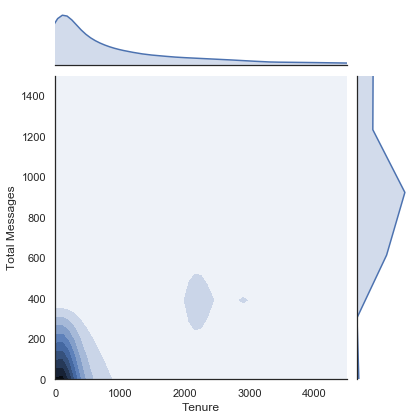

In [295]:
sns.jointplot(
    x="Tenure", 
    y="Total Messages", 
    ylim=(0, 1500), 
    xlim=(0, 4500),
    data=working_data, 
    kind="kde");

<div class="alert alert-info"><b>TODO</b> It might be better to limit the data to the vast majority of the participants first, and then to graph it, rather than calculating the density across the entire spread and then cutting short the graph.</div>

As the density plot is dominated by that bottom-left corner, maybe a scatter plot and trend lines would be more informative.

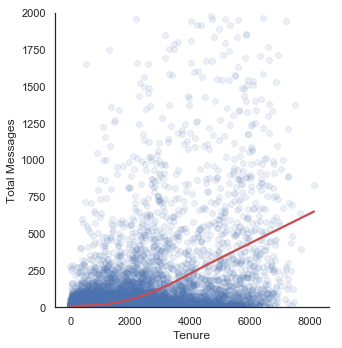

In [279]:
fig = sns.lmplot(
    x="Tenure", 
    y="Total Messages", 
    data=working_data,
    lowess=True,
    scatter_kws={'alpha':0.1},
    line_kws={'color':'r'});
fig.set(ylim=(0,2000)) # hard to see the trend when you include the prominent outliers
fig.savefig('graphs/tenure-total-messages-scatter.png',dpi=300)

While there is a trend towards more messages the longer a time that you've participated, the lowess-smoothed line suggests that that trend is much stronger once participants have been participating for years, and that among shorter-term participants, the distribution is more flat.

Do people who started participating earlier send more messages? While that would seem possible (because you could have a longer tenure and had more time to send more messages), it shouldn't be very strong unless there's been a substantial change in the kind of participations who have joined.

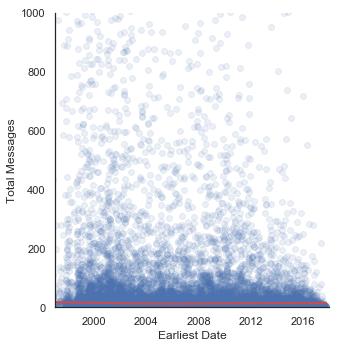

In [493]:
g = sns.lmplot(
    x="Earliest Date", 
    y="Total Messages", 
    data=working_data,
    lowess=True,
    scatter_kws={'alpha':0.1},
    line_kws={'color':'r'});
g.set(ylim=(0,1000)) # hard to see the trend when you include the prominent outliers
g.ax.set_xlim(datetime.date(1997,1,1).toordinal(),datetime.date(2018,1,1).toordinal())
g.ax.xaxis_date()

A flat trend line, as expected. We can ignore further inquiry along those lines, I think.

## Conclusion

We've looked at data on senders to IETF Working Group mailing lists, how many messages they have sent in total and the *tenure* of their participation.

This notebook is exploratory, showing the work in calculating, cleaning, visualizing and interrogating the data, rather than just final results. Our corpus of email archives is large, and messy, but we can still investigate trends from it.

Senders to IETF WG mailing lists are, by the numbers, mostly sending a small number of messages over a short period of time. But there is a long tail, of fewer and fewer people, who have sent thousands of messages over many years, often using multiple email addresses and affiliations. While there is an indication of fewer new email senders in the last few years, the data does *not* suggest domination by the earliest or longest-term participants: new participants join and older participants cease participation regularly. Long-term participation correlates with sending more messages.